Simple FWI Example
==================

In this section we see application of PyFWI for performing FWI.
First, forward modeling is shown and then we estimate a model of subsurface using FWI.


 **1. Forward modeling**



In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages amd modulus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.processing as process
from PyFWI.fwi import FWI



A simple model can be created by using ```model_dataset``` module as

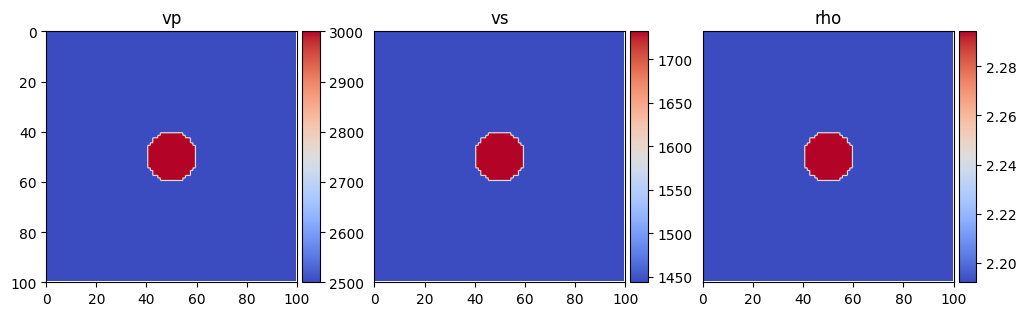

In [2]:
Model = md.ModelGenerator('louboutin')
model = Model()

im = splt.earth_model(model, cmap='coolwarm')

Then we need to create an input dictionary as follow

In [3]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 4,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 1,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.6,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'], 
                                                                 inpa['rec_dis'], 
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'], 
                                                                 inpa['sdo'], 
                                                                 acq_type=inpa['acq_type'])        
rec_loc[:, 1] -= 2 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Finally, we can have the forward modelling as 

In [5]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling 
d_obs = W.forward_modeling(model, show=False)  # show=True can show the propagation of the wave

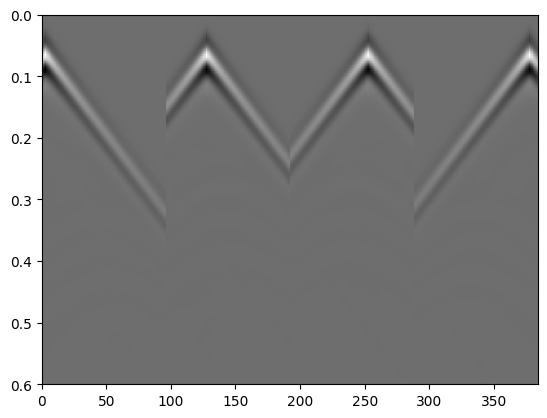

In [6]:
plt.imshow(d_obs["taux"], cmap='gray', 
           aspect="auto", extent=[0, d_obs["taux"].shape[1], inpa['t'], 0])

**2. FWI**

To perform FWI, we need the observed data and an initial model. 


**Note:** For better visualization and avoiding crosstalk, I estimate the model in acoustic media.

Here is a homogeneous initial model.

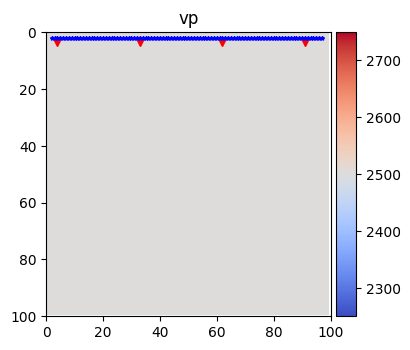

In [7]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(model['rho'])

fig = splt.earth_model(m0, ['vp'], cmap='coolwarm')

fig.axes[0].plot(src_loc[:,0]//inpa["dh"], 
                 src_loc[:,1]//inpa["dh"], "rv", markersize=5)

fig.axes[0].plot(rec_loc[:,0]//inpa["dh"], 
                 rec_loc[:,1]//inpa["dh"], "b*", markersize=3)


Now, we can create a FWI object,

In [8]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)


and call it by providing the [required arguments](https://pyfwi.readthedocs.io/en/latest/sub_doc/inversion.html#full-waveform-inversion).

In [9]:
m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.0008534238440915942 with rms_reg: 0, and rms_data: 0.0008534238440915942, rms_mp: 0.0, rms_model_relation: 0
Parameter number 1 to 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53424D-04    |proj g|=  2.88518D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      0      1      0     0     0   2.885D-09   8.534D-04
  F =   8.5342384409159422E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


2500.0 2500.0
 for f= 45: rms is: 0.014711745083332062 with rms_reg: 0, and rms_data: 0.014711745083332062, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47117D-02    |proj g|=  9.68491D-08


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -1.6002D-12  1.6002D-12
Distance to the stationary point =   1.0000D+00

---------------- exit CAUCHY----------------------

       10000  variables are free at GCP            1


 This problem is unconstrained.


2499.923438712015 2500.0194359996817
 for f= 45: rms is: 0.014710420742630959 with rms_reg: 0, and rms_data: 0.014710420742630959, rms_mp: 0.0, rms_model_relation: 0
2499.6171935600755 2500.097179998408
 for f= 45: rms is: 0.014705114997923374 with rms_reg: 0, and rms_data: 0.014705114997923374, rms_mp: 0.0, rms_model_relation: 0
2498.392212952317 2500.408155993314
 for f= 45: rms is: 0.014683905988931656 with rms_reg: 0, and rms_data: 0.014683905988931656, rms_mp: 0.0, rms_model_relation: 0
2493.492290521284 2501.652059972937
 for f= 45: rms is: 0.014599267393350601 with rms_reg: 0, and rms_data: 0.014599267393350601, rms_mp: 0.0, rms_model_relation: 0
2473.89260079715 2506.6276758914296
 for f= 45: rms is: 0.014264247380197048 with rms_reg: 0, and rms_data: 0.014264247380197048, rms_mp: 0.0, rms_model_relation: 0
2395.493841900615 2526.530139565399
 for f= 45: rms is: 0.012987682595849037 with rms_reg: 0, and rms_data: 0.012987682595849037, rms_mp: 0.0, rms_model_relation: 0
2081.898

Here is the estimated model

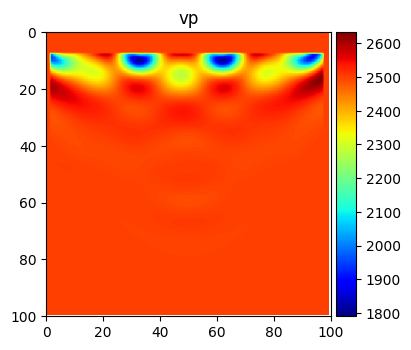

In [10]:
# Time to plot the results
fig = splt.earth_model(m_est, ['vp'], cmap='jet')


As the energy of reflected waves is weaker than one of the transmitted waves, FWI with surface geometry is more difficult than with cross-well. In this case, there are two ways to obtain a better estimate.
1. Scaling the gradient with the energy of the transmitted wave using the key `energy_balancing` in `inpa`.

In [11]:
inpa['energy_balancing'] = True

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.0008534238440915942 with rms_reg: 0, and rms_data: 0.0008534238440915942, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53424D-04    |proj g|=  3.90222D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      0      1      0     0     0   3.902D-10   8.534D-04
  F =   8.5342384409159422E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Parameter number 1 to 1


 This problem is unconstrained.


2500.0 2500.0
 for f= 45: rms is: 0.014711745083332062 with rms_reg: 0, and rms_data: 0.014711745083332062, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47117D-02    |proj g|=  1.10023D-08


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -3.9574D-14  3.9574D-14
Distance to the stationary point =   1.0000D+00

---------------- exit CAUCHY----------------------

       10000  variables are free at GCP            1


 This problem is unconstrained.


2499.944694274747 2500.0274196980413
 for f= 45: rms is: 0.014710546471178532 with rms_reg: 0, and rms_data: 0.014710546471178532, rms_mp: 0.0, rms_model_relation: 0
2499.7234713737334 2500.137098490207
 for f= 45: rms is: 0.014705754816532135 with rms_reg: 0, and rms_data: 0.014705754816532135, rms_mp: 0.0, rms_model_relation: 0
2498.838579769681 2500.575813658869
 for f= 45: rms is: 0.014686603099107742 with rms_reg: 0, and rms_data: 0.014686603099107742, rms_mp: 0.0, rms_model_relation: 0
2495.299013353471 2502.3306743335174
 for f= 45: rms is: 0.014610320329666138 with rms_reg: 0, and rms_data: 0.014610320329666138, rms_mp: 0.0, rms_model_relation: 0
2481.14074768863 2509.3501170321106
 for f= 45: rms is: 0.01431039534509182 with rms_reg: 0, and rms_data: 0.01431039534509182, rms_mp: 0.0, rms_model_relation: 0
2424.507685029268 2537.427887826483
 for f= 45: rms is: 0.013201620429754257 with rms_reg: 0, and rms_data: 0.013201620429754257, rms_mp: 0.0, rms_model_relation: 0
 LINE SEA

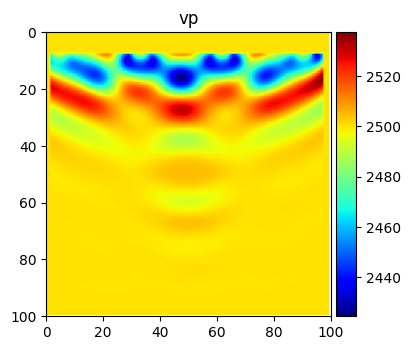

In [12]:
fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

2. You can also add a key called `sd` to `inpa` to apply a gain on data. In this case, the gain should apply manually to the observed data.

In [13]:
inpa['energy_balancing'] = False


inpa['sd'] = 1/inpa['dt']

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 53.33898162841797 with rms_reg: 0, and rms_data: 53.33898162841797, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33390D+01    |proj g|=  7.21293D-07


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -1.4966D-10  1.4966D-10
Distance to the stationary point =   1.0000D+00

---------------- exit CAUCHY----------------------

       10000  variables are free at GCP            1


 This problem is unconstrained.


2499.941040170681 2500.0128636606546
 for f= 25: rms is: 53.33580017089844 with rms_reg: 0, and rms_data: 53.33580017089844, rms_mp: 0.0, rms_model_relation: 0
2499.7052008534056 2500.0643183032726
 for f= 25: rms is: 53.32314682006836 with rms_reg: 0, and rms_data: 53.32314682006836, rms_mp: 0.0, rms_model_relation: 0
2498.7618435843024 2500.2701368737457
 for f= 25: rms is: 53.2723503112793 with rms_reg: 0, and rms_data: 53.2723503112793, rms_mp: 0.0, rms_model_relation: 0
2494.9884145078913 2501.093411155637
 for f= 25: rms is: 53.06951904296875 with rms_reg: 0, and rms_data: 53.06951904296875, rms_mp: 0.0, rms_model_relation: 0
2479.894698202246 2504.3865082832035
 for f= 25: rms is: 52.26191711425781 with rms_reg: 0, and rms_data: 52.26191711425781, rms_mp: 0.0, rms_model_relation: 0
2419.5198329796667 2517.558896793469
 for f= 25: rms is: 49.10051345825195 with rms_reg: 0, and rms_data: 49.10051345825195, rms_mp: 0.0, rms_model_relation: 0
2178.020372089348 2570.24845083453
 for 

 This problem is unconstrained.


1841.12642918438 2600.989599965276
 for f= 45: rms is: 651.9013061523438 with rms_reg: 0, and rms_data: 651.9013061523438, rms_mp: 0.0, rms_model_relation: 0
1841.302609738285 2600.9782173780263
 for f= 45: rms is: 651.6236572265625 with rms_reg: 0, and rms_data: 651.6236572265625, rms_mp: 0.0, rms_model_relation: 0
1842.0073319539054 2600.932687029028
 for f= 45: rms is: 650.51513671875 with rms_reg: 0, and rms_data: 650.51513671875, rms_mp: 0.0, rms_model_relation: 0
1844.8262208163871 2600.750565633034
 for f= 45: rms is: 646.117431640625 with rms_reg: 0, and rms_data: 646.117431640625, rms_mp: 0.0, rms_model_relation: 0
1856.101776266314 2600.3231914931644
 for f= 45: rms is: 629.102783203125 with rms_reg: 0, and rms_data: 629.102783203125, rms_mp: 0.0, rms_model_relation: 0
1855.298503656921 2599.616983685037
 for f= 45: rms is: 569.7529907226562 with rms_reg: 0, and rms_data: 569.7529907226562, rms_mp: 0.0, rms_model_relation: 0
 LINE SEARCH           5  times; norm of step =    

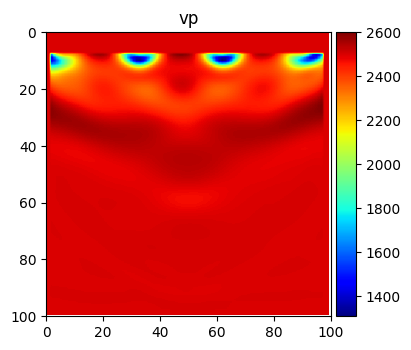

In [14]:
d_obs = process.prepare_residual(d_obs, inpa['sd'])

fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

Considering both these options, we have

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 53.33898162841797 with rms_reg: 0, and rms_data: 53.33898162841797, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33390D+01    |proj g|=  9.75556D-08


ITERATION     1

---------------- CAUCHY entered-------------------
 There are            0   breakpoints 

 GCP found in this segment
Piece      1 --f1, f2 at start point  -4.3619D-12  4.3619D-12
Distance to the stationary point =   1.0000D+00

---------------- exit CAUCHY----------------------

       10000  variables are free at GCP            1


 This problem is unconstrained.


2499.953289638838 2500.0219632999147
 for f= 25: rms is: 53.3359260559082 with rms_reg: 0, and rms_data: 53.3359260559082, rms_mp: 0.0, rms_model_relation: 0
2499.7664481941915 2500.1098164995724
 for f= 25: rms is: 53.32379150390625 with rms_reg: 0, and rms_data: 53.32379150390625, rms_mp: 0.0, rms_model_relation: 0
2499.019082415604 2500.4612292982033
 for f= 25: rms is: 53.27518081665039 with rms_reg: 0, and rms_data: 53.27518081665039, rms_mp: 0.0, rms_model_relation: 0
2496.0296193012537 2501.866880492727
 for f= 25: rms is: 53.081199645996094 with rms_reg: 0, and rms_data: 53.081199645996094, rms_mp: 0.0, rms_model_relation: 0
2484.0717668438533 2507.489485270822
 for f= 25: rms is: 52.31187438964844 with rms_reg: 0, and rms_data: 52.31187438964844, rms_mp: 0.0, rms_model_relation: 0
2436.240357014252 2529.979904383203
 for f= 25: rms is: 49.34898376464844 with rms_reg: 0, and rms_data: 49.34898376464844, rms_mp: 0.0, rms_model_relation: 0
 LINE SEARCH           5  times; norm of

 This problem is unconstrained.


2028.966106589278 2655.897732314121
 for f= 45: rms is: 731.529052734375 with rms_reg: 0, and rms_data: 731.529052734375, rms_mp: 0.0, rms_model_relation: 0
2029.045046061854 2655.881397095081
 for f= 45: rms is: 731.2896118164062 with rms_reg: 0, and rms_data: 731.2896118164062, rms_mp: 0.0, rms_model_relation: 0
2029.3608039521582 2655.8160562189187
 for f= 45: rms is: 730.333251953125 with rms_reg: 0, and rms_data: 730.333251953125, rms_mp: 0.0, rms_model_relation: 0
2030.623835513375 2655.5546927142705
 for f= 45: rms is: 726.5352783203125 with rms_reg: 0, and rms_data: 726.5352783203125, rms_mp: 0.0, rms_model_relation: 0
2035.6759617582422 2654.509238695677
 for f= 45: rms is: 711.7901611328125 with rms_reg: 0, and rms_data: 711.7901611328125, rms_mp: 0.0, rms_model_relation: 0
2035.844003000915 2653.012641597949
 for f= 45: rms is: 659.8028564453125 with rms_reg: 0, and rms_data: 659.8028564453125, rms_mp: 0.0, rms_model_relation: 0
 LINE SEARCH           5  times; norm of step 

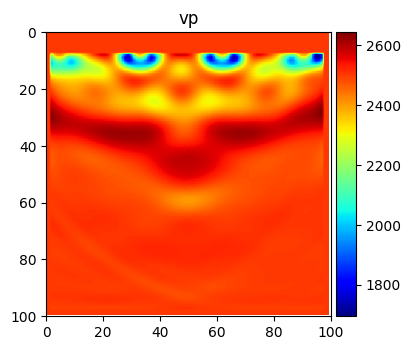

In [15]:
inpa['energy_balancing'] = True

fwi = FWI(d_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)

m_est, _ = fwi(m0, method="lbfgs", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

fig = splt.earth_model(m_est, ['vp'], cmap='jet')

Please note a better choice of gain is very important. Here I multiply data by a constant value to improve the gradient.